In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'C:/Users/Bruker/Desktop/Thesis/Data xlsx/'

# Initialize a counter for the total number of plots
total_plots = 0

# Dictionary to store all values for each meter serial number
all_values_dict = {}

# Loop through each file in the given file path
for file_name in os.listdir(file_path):
    if file_name.endswith('.xlsx') and not file_name.startswith('~$'):
        file_full_path = os.path.join(file_path, file_name)
        
        # Read the Excel file
        xls = pd.ExcelFile(file_full_path, engine='openpyxl')
        
        # Check if the sheet "A+" exists
        if 'A+' in xls.sheet_names:
            df = pd.read_excel(file_full_path, sheet_name='A+', engine='openpyxl')
            
            # Check if the necessary columns exist
            if 'meterSerialNumber' in df.columns and 'value' in df.columns:
                # Loop through each meter serial number in the sheet "A+"
                for meter_serial_number in df['meterSerialNumber'].unique():
                    meter_data = df[df['meterSerialNumber'] == meter_serial_number]
                    values = meter_data['value'].tolist()
                    
                    # Store the values in the dictionary
                    if meter_serial_number not in all_values_dict:
                        all_values_dict[meter_serial_number] = []
                    all_values_dict[meter_serial_number].extend(values)
                    
                    # Plot the values for each MeterSerialNumber
                    plt.figure(figsize=(10, 6))
                    plt.plot(values, label=f'{meter_serial_number}')
                    plt.xlabel('Index')
                    plt.ylabel('Value')
                    plt.title(f'Values for MeterSerialNumber {meter_serial_number} in {file_name}')
                    plt.legend()
                    plt.close()
                    
                    # Increment the total plots counter
                    total_plots += 1
            else:
                print(f'File: {file_name} does not contain the required columns.')

# Print the total number of plots
print(f'Total number of plots: {total_plots}')

# Print the stored values for each meter serial number
for meter_serial_number, values in all_values_dict.items():
    print(f'MeterSerialNumber: {meter_serial_number}, Total Values: {len(values)}, Values: {values}')

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'C:/Users/Bruker/Desktop/Thesis/Data xlsx/'

# Initialize a counter for the total number of plots
total_plots = 0

# Dictionary to store all values for each meter serial number
all_values_dict = {}

# List to store the names of processed files
processed_files = []

# Loop through each file in the given file path
for file_name in os.listdir(file_path):
    if file_name.endswith('.xlsx') and not file_name.startswith('~$'):
        file_full_path = os.path.join(file_path, file_name)
        
        # Read the Excel file
        xls = pd.ExcelFile(file_full_path, engine='openpyxl')
        
        # Check if the sheet "A+" exists
        if 'A+' in xls.sheet_names:
            df = pd.read_excel(file_full_path, sheet_name='A+', engine='openpyxl')
            
            # Check if the necessary columns exist
            if ('meterSerialNumber' in df.columns or 'usagePointId' in df.columns) and 'value' in df.columns:
                # Add the file name to the list of processed files
                processed_files.append(file_name)
                
                # Determine the column to use for meter serial numbers
                meter_column = 'meterSerialNumber' if 'meterSerialNumber' in df.columns else 'usagePointId'
                
                # Loop through each meter serial number in the sheet "A+"
                for meter_serial_number in df[meter_column].unique():
                    meter_data = df[df[meter_column] == meter_serial_number]
                    values = meter_data['value'].tolist()
                    
                    # Store the values in the dictionary
                    if meter_serial_number not in all_values_dict:
                        all_values_dict[meter_serial_number] = []
                    all_values_dict[meter_serial_number].extend(values)
                '''
                    # Plot the values for each MeterSerialNumber
                    plt.figure(figsize=(10, 6))
                    plt.plot(values, label=f'{meter_serial_number}')
                    plt.xlabel('Index')
                    plt.ylabel('Value')
                    plt.title(f'Active consumed values in {file_name} for {meter_column} {meter_serial_number}')
                    plt.legend()
                    plt.show()
'''


In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


# Prepare the data for LSTM
sequence_length = 24
X = []
y = []

for meter_serial_number, values in all_values_dict.items():
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(np.array(values).reshape(-1, 1))
    
    for i in range(len(scaled_values) - sequence_length):
        X.append(scaled_values[i:i + sequence_length])
        y.append(scaled_values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape the data to fit the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print data shapes to verify
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

# Ensure data types are correct
print(f'X_train dtype: {X_train.dtype}')
print(f'y_train dtype: {y_train.dtype}')
print(f'X_test dtype: {X_test.dtype}')
print(f'y_test dtype: {y_test.dtype}')


X_train shape: (765441, 24, 1)
y_train shape: (765441, 1)
X_test shape: (191361, 24, 1)
y_test shape: (191361, 1)
X_train dtype: float64
y_train dtype: float64
X_test dtype: float64
y_test dtype: float64


In [29]:

# Build the LSTM model

# Define sequence length
sequence_length = 24  

# Build the LSTM model
model = Sequential()

# First LSTM layer with additional parameters
model.add(LSTM(
    units=75,  
    activation='tanh', 
    recurrent_activation='sigmoid', 
    dropout=0.2,  
    recurrent_dropout=0.3,  
    return_sequences=True,  
    input_shape=(sequence_length, 1) 
))
# Second LSTM layer with additional parameters
model.add(LSTM(
    units=75,  
    activation='tanh',  
    recurrent_activation='sigmoid',  
    dropout=0.2,  
    recurrent_dropout=0.3  
))

model.add(BatchNormalization())  # Add batch normalization

# Output layer
model.add(Dense(1))

# Compile 
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary 
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 75)            23100     
                                                                 
 lstm_3 (LSTM)               (None, 75)                45300     
                                                                 
 batch_normalization_1 (Bat  (None, 75)                300       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 76        
                                                                 
Total params: 68776 (268.66 KB)
Trainable params: 68626 (268.07 KB)
Non-trainable params: 150 (600.00 Byte)
_________________________________________________________________


In [31]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')




Epoch 1/20
19136/19136 [==============================] - 1097s 57ms/step - loss: 0.0051 - val_loss: 0.0107
Epoch 2/20
19136/19136 [==============================] - 1089s 57ms/step - loss: 0.0049 - val_loss: 0.0096
Epoch 3/20
19136/19136 [==============================] - 1102s 58ms/step - loss: 0.0047 - val_loss: 0.0102
Epoch 4/20
19136/19136 [==============================] - 1107s 58ms/step - loss: 0.0046 - val_loss: 0.0099
Epoch 5/20
19136/19136 [==============================] - 1111s 58ms/step - loss: 0.0045 - val_loss: 0.0091
Epoch 6/20
19136/19136 [==============================] - 1115s 58ms/step - loss: 0.0044 - val_loss: 0.0094
Epoch 7/20
19136/19136 [==============================] - 1135s 59ms/step - loss: 0.0043 - val_loss: 0.0106
Epoch 8/20
19136/19136 [==============================] - 1145s 60ms/step - loss: 0.0043 - val_loss: 0.0098
Epoch 9/20
19136/19136 [==============================] - 1198s 63ms/step - loss: 0.0042 - val_loss: 0.0104
Epoch 10/20
19136/19136 [===

In [19]:
# Save the trained model
model.save('AC_New_trained_model.h5')

C:\Users\Bruker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
# Save the trained model
model.save('99AC_New_trained_model.h5')

# Save the training history
np.save('history.npy', history.history)

C:\Users\Bruker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5981/5981 [==============================] - 91s 15ms/step - loss: 0.0103
Test Loss: 0.010296350345015526


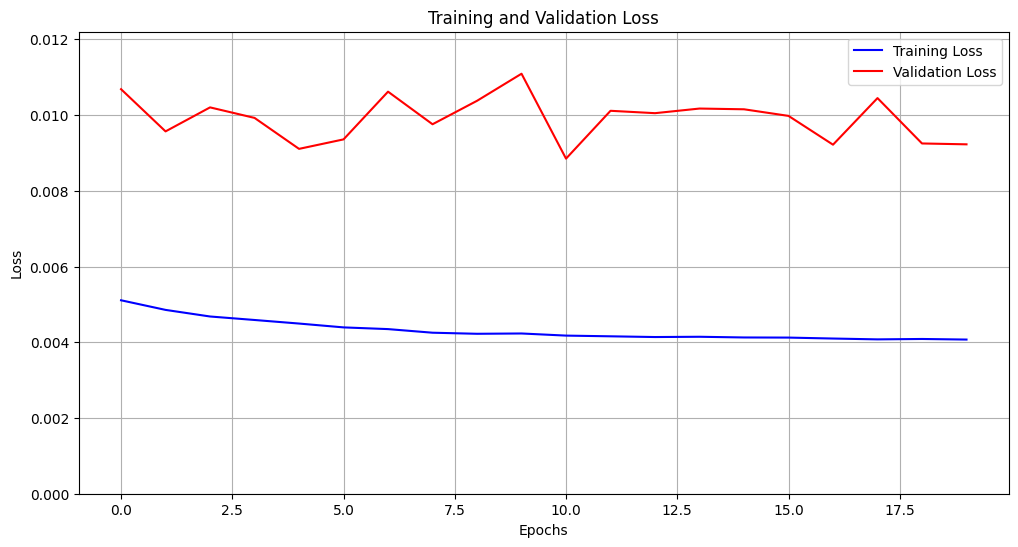

In [35]:
import matplotlib.pyplot as plt


# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Plot training and validation loss
plt.figure(figsize=(12, 6))  # Adjust the figure size
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])) * 1.1)  # Adjust y-axis limits if needed
plt.show()

In [23]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

5447/5447 [==============================] - 101s 18ms/step - loss: 0.0108
Test Loss: 0.010750831104815006


In [24]:
# Make predictions
y_pred = model.predict(X_test)


5447/5447 [==============================] - 114s 21ms/step


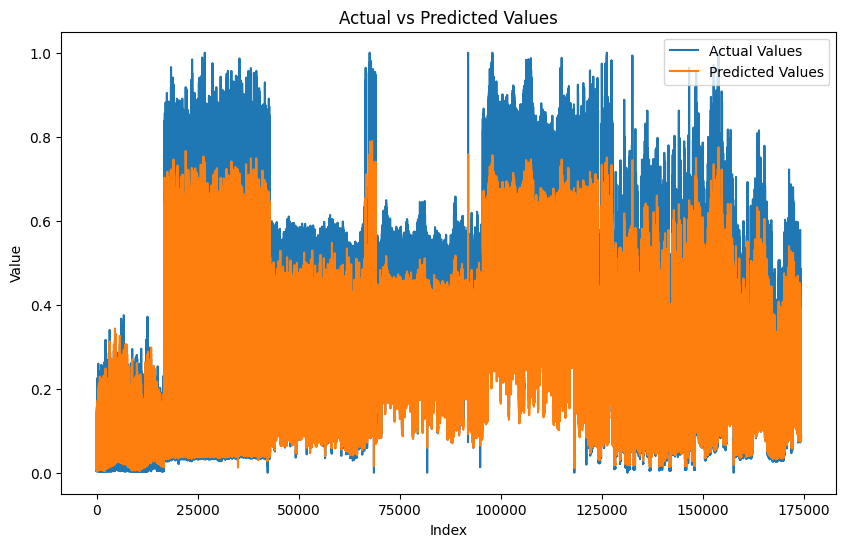

In [25]:

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

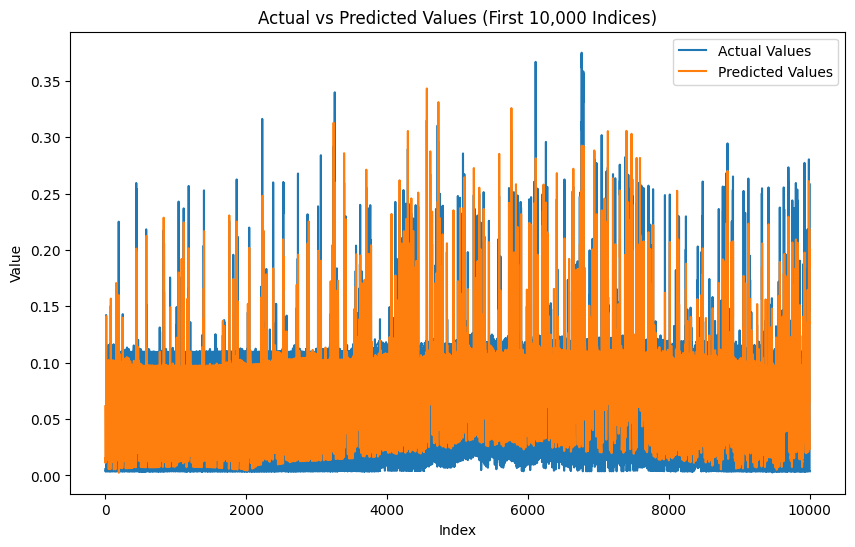

In [37]:
# Plot predictions vs actual values for the first 10,000 indices
plt.figure(figsize=(10, 6))
plt.plot(y_test[:10000], label='Actual Values')
plt.plot(y_pred[:10000], label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (First 10,000 Indices)')
plt.legend()
plt.show()

In [29]:
print(len(X_test))
print(len(y_test))

174283
174283


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 0.010750822072584371
Mean Absolute Error: 0.07090815224215305


In [37]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.8213503568616305


5447/5447 [==============================] - 88s 16ms/step - loss: 0.0108
Test Loss: 0.010750831104815006


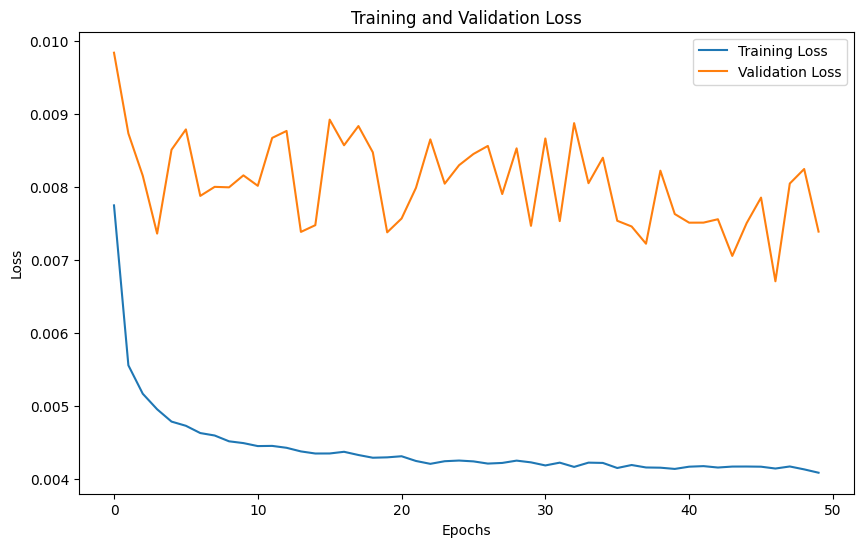

In [34]:

# Evaluate the model
model.load_weights('AC_New_trained_model.h5')
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Analyze training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


5981/5981 [==============================] - 107s 18ms/step
Mean Squared Error: 0.010296349703855324
Mean Absolute Error: 0.06944307958454747


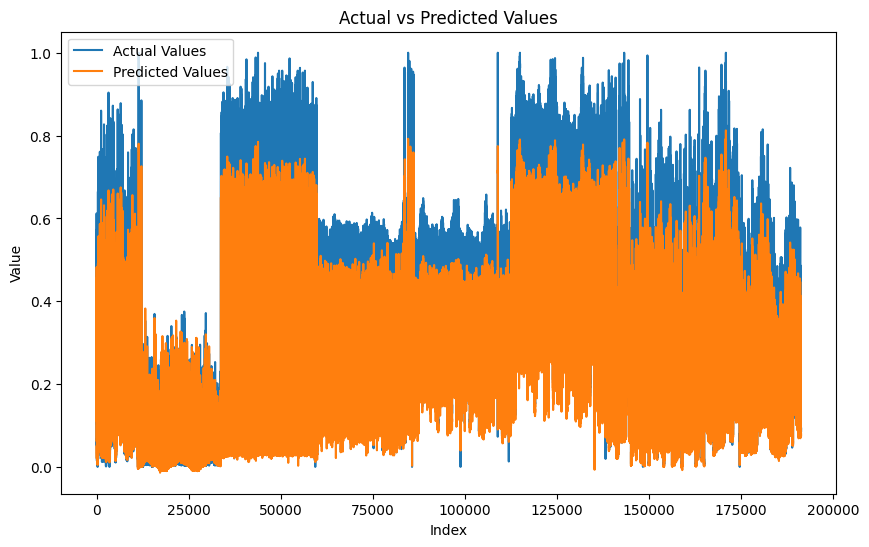

In [36]:

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'C:/Users/Bruker/Desktop/Thesis/Data xlsx/'

# Loop through each file in the given file path
for file_name in os.listdir(file_path):
    if file_name.endswith('.xlsx'):
        file_full_path = os.path.join(file_path, file_name)
        
        # Read the Excel file
        xls = pd.ExcelFile(file_full_path)
        
        # Check if the sheet "A+" exists
        if 'A+' in xls.sheet_names:
            df = pd.read_excel(file_full_path, sheet_name='A+')
            
            # Debug: Print the first few rows of the DataFrame
            print(f'File: {file_name}, DataFrame head:\n', df.head())
            
            # Check if the necessary columns exist
            if 'meterSerialNumber' in df.columns and 'value' in df.columns:
                # Loop through each meter serial number in the sheet "A+"
                for meter_serial_number in df['meterSerialNumber'].unique():
                    meter_data = df[df['meterSerialNumber'] == meter_serial_number]
                    values = meter_data['value'].tolist()
                    print(f'File: {file_name}, meterSerialNumber: {meter_serial_number}, Values: {values}')
                    
                    # Plot the values for each MeterSerialNumber
                    plt.figure(figsize=(10, 6))
                    plt.plot(values, label=f'{meter_serial_number}')
                    plt.xlabel('Index')
                    plt.ylabel('Value')
                    plt.title(f'Values for MeterSerialNumber {meter_serial_number} in {file_name}')
                    plt.legend()
                    plt.show()
            else:
                print(f'File: {file_name} does not contain the required columns.')